In [178]:
import morphs
import numpy as np
import scipy as sp
import pandas as pd
%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns
from glob import glob
import pickle
from joblib import Parallel, delayed

In [57]:
def load_block_samples_from_pkl(pkl_path):
    with open(pkl_path, 'rb') as f:
        return pickle.load(f)

def load_incomplete_neurometric_null_all(num_shuffles):
    nshuffle_dir = morphs.paths.num_shuffle_dir(num_shuffles)
    return pd.concat([load_block_samples_from_pkl(pkl_path) for pkl_path in glob((nshuffle_dir / '*.pkl').as_posix())])

In [123]:
def gen_ks_df(block_path, block_group):
    print block
    shuffled_df, unshuffle_df = shuffle_ks_df(block_group)
    ks_df = merge_ks_dfs(shuffled_df, unshuffle_df)
    ks_df['neuro_subj'] = morphs.data.parse.bird_id(block_path)
    ks_df['block_path'] = block_path
    return ks_df

def shuffle_ks_df(samples_df):
    shuffled_grouped = samples_df.groupby('shuffled')
    shuffled = shuffled_grouped.get_group(True)['errors'].values
    fit = shuffled_grouped.get_group(False)['errors'].values

    for was_shuffled, shuffle_group in shuffled_grouped:
        grouped = shuffle_group.groupby(['shuffle_index', 'subj'])
        temp_results = np.zeros(len(grouped))
        temp_p_results = np.zeros(len(grouped))
        temp_subj_results = ['' for i in xrange(len(grouped))]
        for i, ((shuffle_index, subj), group) in enumerate(grouped):
            temp_results[i], temp_p_results[i] = sp.stats.mstats.ks_twosamp(group['errors'].values, shuffled, alternative='greater')
            temp_subj_results[i] = subj

        df  = pd.DataFrame(columns=['subj', 'ks_stat', 'ks_p'])
        df['subj'] = temp_subj_results
        df['ks_stat'] = temp_results
        df['ks_p'] = temp_p_results

        if was_shuffled:
            shuffled_df = df
        else:
            unshuffle_df = df

    return shuffled_df, unshuffle_df

def merge_ks_dfs(shuffled_df, unshuffle_df, reset_index=True):
    temp_df = shuffled_df.merge(unshuffle_df, on=('subj'), suffixes=('_shuffled', '_unshuffled'))
    temp_df['p'] = temp_df['ks_stat_shuffled'] > temp_df['ks_stat_unshuffled']
    ks_df = temp_df.groupby('subj').apply(np.mean)
    if reset_index:
        ks_df = ks_df.reset_index()
    del ks_df['ks_stat_shuffled']
    return ks_df

In [179]:
NUM_SHUFFLES = 2048
all_samples_df = load_incomplete_neurometric_null_all(NUM_SHUFFLES)

print len(all_samples_df['block'].unique()), '/ 39'

39 / 39


In [180]:
PARALLEL = True

if PARALLEL:
    all_ks = Parallel(n_jobs=morphs.parallel.N_JOBS)(delayed(gen_ks_df)(block, block_group) for block, block_group in all_samples_df.groupby('block'))
else:
    all_ks = [gen_ks_df(block, block_group) for block, block_group in all_samples_df.groupby('block')]

all_ks_df = pd.concat(all_ks, ignore_index=True)

In [170]:
all_ks_df = pd.concat(all_ks, ignore_index=True)

In [181]:
all_ks_df.loc[all_ks_df['neuro_subj'] == 'st1107', 'neuro_subj'] = 'B1107'

In [182]:
for (behave_subj, subj), group in all_ks_df.groupby(['subj', 'neuro_subj']):
    if subj == behave_subj:
        all_ks_df.loc[group.index, 'class'] = 'self'
    elif not subj in morphs.subj.TRAINING:
        all_ks_df.loc[group.index, 'class'] = 'naive'
    elif morphs.subj.TRAINING[subj] is morphs.subj.TRAINING[behave_subj]:
        all_ks_df.loc[group.index, 'class'] = 'same training cond'
    else:
        all_ks_df.loc[group.index, 'class'] = 'diff training cond'
    print subj, behave_subj, all_ks_df.loc[group.index[0], ['subj', 'neuro_subj', 'class']].values

B1082 B1082 ['B1082' 'B1082' 'self']
B1096 B1082 ['B1082' 'B1096' 'naive']
B1101 B1082 ['B1082' 'B1101' 'diff training cond']
B1107 B1082 ['B1082' 'B1107' 'same training cond']
B1134 B1082 ['B1082' 'B1134' 'naive']
B1183 B1082 ['B1082' 'B1183' 'naive']
B1218 B1082 ['B1082' 'B1218' 'same training cond']
B1229 B1082 ['B1082' 'B1229' 'naive']
B1082 B1088 ['B1088' 'B1082' 'diff training cond']
B1096 B1088 ['B1088' 'B1096' 'naive']
B1101 B1088 ['B1088' 'B1101' 'diff training cond']
B1107 B1088 ['B1088' 'B1107' 'diff training cond']
B1134 B1088 ['B1088' 'B1134' 'naive']
B1183 B1088 ['B1088' 'B1183' 'naive']
B1218 B1088 ['B1088' 'B1218' 'diff training cond']
B1229 B1088 ['B1088' 'B1229' 'naive']
B1082 B1101 ['B1101' 'B1082' 'diff training cond']
B1096 B1101 ['B1101' 'B1096' 'naive']
B1101 B1101 ['B1101' 'B1101' 'self']
B1107 B1101 ['B1101' 'B1107' 'diff training cond']
B1134 B1101 ['B1101' 'B1134' 'naive']
B1183 B1101 ['B1101' 'B1183' 'naive']
B1218 B1101 ['B1101' 'B1218' 'diff training cond'

In [183]:
floor_val = 1.0 / NUM_SHUFFLES
all_ks_df.loc[all_ks_df['p'] < floor_val, 'p'] = floor_val

In [184]:
all_ks_df['ks_p_floored'] = all_ks_df['ks_p_unshuffled']
all_ks_df.loc[all_ks_df['ks_p_floored'] < floor_val, 'ks_p_floored'] = floor_val

In [185]:
class_order = ['naive', 'diff training cond', 'same training cond', 'self']

In [186]:
for sym, crit in (('*', .05), ('**', .01), ('***', .001)):
    all_ks_df[sym] = all_ks_df['p'] < crit
    all_ks_df['ks'+sym] = all_ks_df['ks_p_unshuffled'] < crit
all_ks_df['count'] = 1
sig_df = all_ks_df.groupby('class').agg('sum')
sig_df['floor_count'] = all_ks_df[all_ks_df['p'] <= floor_val].groupby('class').agg('sum')['count']
sig_df

,ks_p_shuffled,ks_stat_unshuffled,ks_p_unshuffled,p,ks_p_floored,*,ks*,**,ks**,***,ks***,count,floor_count
class,,,,,,,,,,,,,
diff training cond,45.009506,28.122822,23.295084,11.136230,23.304107,53.0,42.0,39.0,32.0,25.0,22.0,90,22
naive,77.904260,48.270603,37.645809,8.485352,37.651715,117.0,87.0,68.0,62.0,33.0,26.0,160,28
same training cond,21.850929,14.127369,6.232442,1.162109,6.233325,36.0,27.0,20.0,18.0,11.0,5.0,43,8
self,11.538715,4.817280,5.209148,0.963379,5.209148,15.0,9.0,7.0,3.0,3.0,1.0,19,3


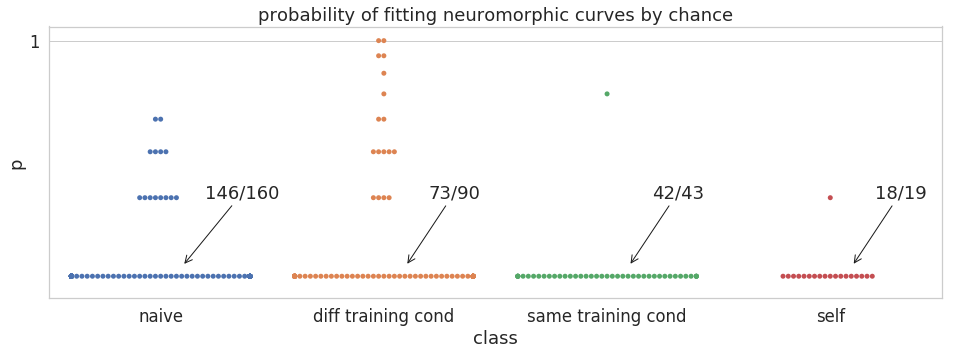

In [91]:
# 8
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
f = plt.figure(figsize=(16,5))
ax = f.gca()
ax.set_yscale('log')
plt.yticks([1, .05, .01, .001], ['1', '.05', '.01', '.001'])
g = sns.swarmplot(data=all_ks_df, x='class', order=class_order, y='p', size=5, ax=ax)

for i, cls in enumerate(class_order):
    if sig_df.loc[cls, 'floor_count'] > 0:
        label = '%d/%d' % (sig_df.loc[cls, 'floor_count'], sig_df.loc[cls, 'count'])
        plt.annotate(label, xy=(0.1 + i, floor_val * 1.1), arrowprops=dict(arrowstyle='->', color='k'), xytext=(0.2 + i, floor_val * 2.0));
ax.set_title('probability of fitting neuromorphic curves by chance');

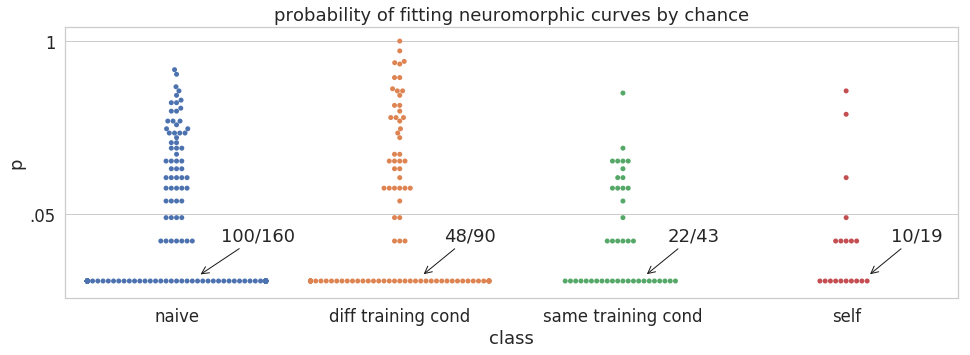

In [106]:
# 64
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
f = plt.figure(figsize=(16,5))
ax = f.gca()
ax.set_yscale('log')
plt.yticks([1, .05, .01, .001], ['1', '.05', '.01', '.001'])
g = sns.swarmplot(data=all_ks_df, x='class', order=class_order, y='p', size=5, ax=ax)

for i, cls in enumerate(class_order):
    if sig_df.loc[cls, 'floor_count'] > 0:
        label = '%d/%d' % (sig_df.loc[cls, 'floor_count'], sig_df.loc[cls, 'count'])
        plt.annotate(label, xy=(0.1 + i, floor_val * 1.1), arrowprops=dict(arrowstyle='->', color='k'), xytext=(0.2 + i, floor_val * 2.0));
ax.set_title('probability of fitting neuromorphic curves by chance');

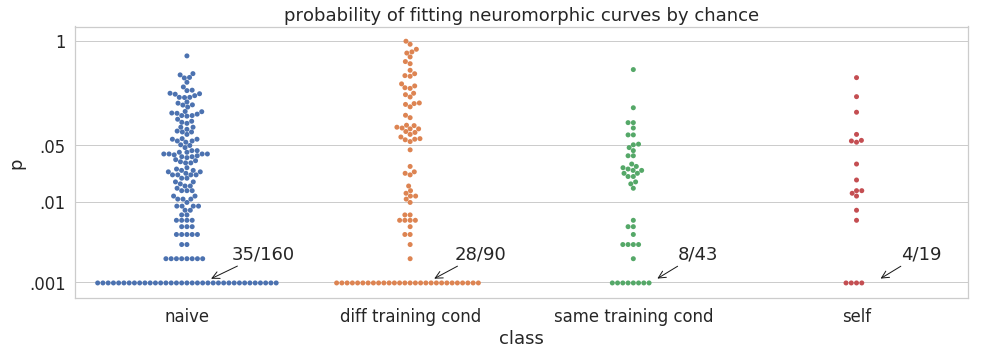

In [122]:
#1024
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
f = plt.figure(figsize=(16,5))
ax = f.gca()
ax.set_yscale('log')
plt.yticks([1, .05, .01, .001], ['1', '.05', '.01', '.001'])
g = sns.swarmplot(data=all_ks_df, x='class', order=class_order, y='p', size=5, ax=ax)

for i, cls in enumerate(class_order):
    if sig_df.loc[cls, 'floor_count'] > 0:
        label = '%d/%d' % (sig_df.loc[cls, 'floor_count'], sig_df.loc[cls, 'count'])
        plt.annotate(label, xy=(0.1 + i, floor_val * 1.1), arrowprops=dict(arrowstyle='->', color='k'), xytext=(0.2 + i, floor_val * 2.0));
ax.set_title('probability of fitting neuromorphic curves by chance');

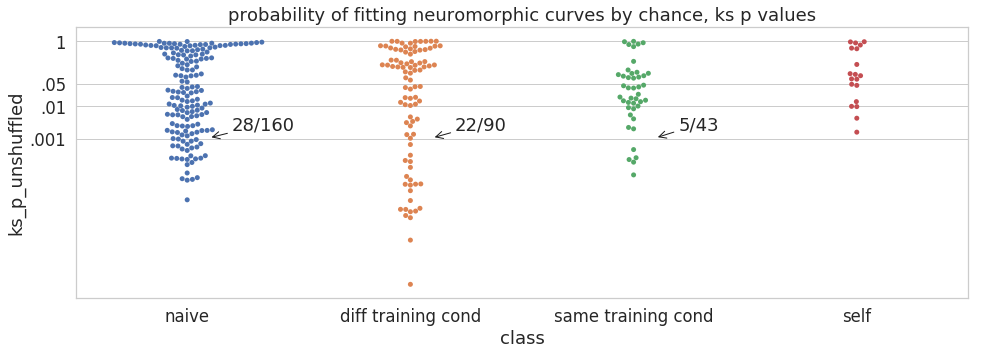

In [140]:
#1024 - ks
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
f = plt.figure(figsize=(16,5))
ax = f.gca()
ax.set_yscale('log')
plt.yticks([1, .05, .01, .001], ['1', '.05', '.01', '.001'])
g = sns.swarmplot(data=all_ks_df, x='class', order=class_order, y='ks_p_unshuffled', size=5, ax=ax)

for i, cls in enumerate(class_order):
    if sig_df.loc[cls, 'ks***'] > 0:
        label = '%d/%d' % (sig_df.loc[cls, 'ks***'], sig_df.loc[cls, 'count'])
        plt.annotate(label, xy=(0.1 + i, floor_val * 1.1), arrowprops=dict(arrowstyle='->', color='k'), xytext=(0.2 + i, floor_val * 2.0));
ax.set_title('probability of fitting neuromorphic curves by chance, ks p values');

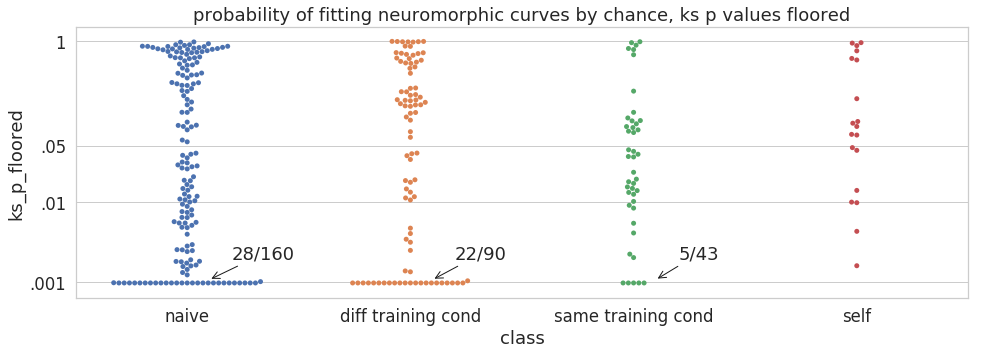

In [177]:
#1024 - ks floored
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
f = plt.figure(figsize=(16,5))
ax = f.gca()
ax.set_yscale('log')
plt.yticks([1, .05, .01, .001], ['1', '.05', '.01', '.001'])
g = sns.swarmplot(data=all_ks_df, x='class', order=class_order, y='ks_p_floored', size=5, ax=ax)

for i, cls in enumerate(class_order):
    if sig_df.loc[cls, 'ks***'] > 0:
        label = '%d/%d' % (sig_df.loc[cls, 'ks***'], sig_df.loc[cls, 'count'])
        plt.annotate(label, xy=(0.1 + i, floor_val * 1.1), arrowprops=dict(arrowstyle='->', color='k'), xytext=(0.2 + i, floor_val * 2.0));
ax.set_title('probability of fitting neuromorphic curves by chance, ks p values floored');

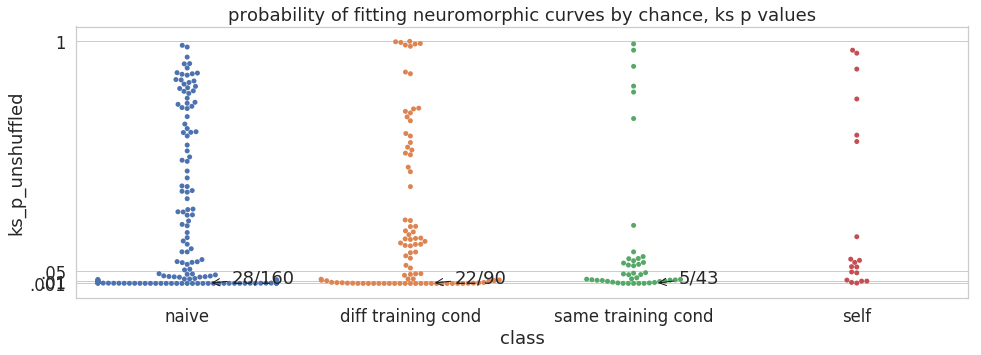

In [158]:
#1024 - ks
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
f = plt.figure(figsize=(16,5))
ax = f.gca()
# ax.set_yscale('log')
plt.yticks([1, .05, .01, .001], ['1', '.05', '.01', '.001'])
g = sns.swarmplot(data=all_ks_df, x='class', order=class_order, y='ks_p_unshuffled', size=5, ax=ax)

for i, cls in enumerate(class_order):
    if sig_df.loc[cls, 'ks***'] > 0:
        label = '%d/%d' % (sig_df.loc[cls, 'ks***'], sig_df.loc[cls, 'count'])
        plt.annotate(label, xy=(0.1 + i, floor_val * 1.1), arrowprops=dict(arrowstyle='->', color='k'), xytext=(0.2 + i, floor_val * 2.0));
ax.set_title('probability of fitting neuromorphic curves by chance, ks p values');

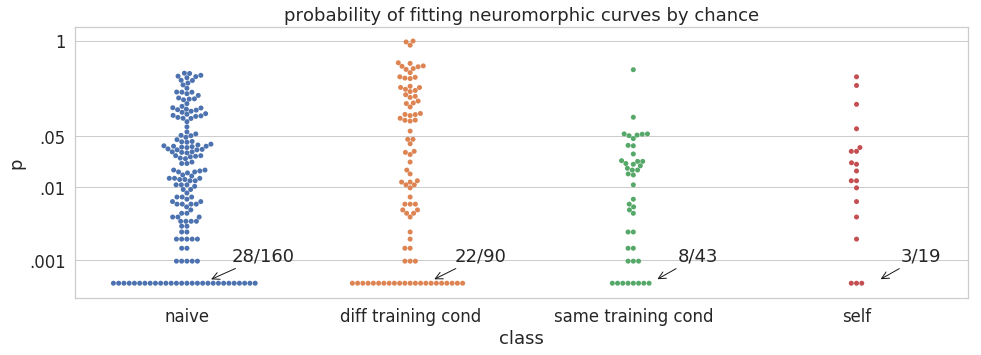

In [187]:
#2048
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
f = plt.figure(figsize=(16,5))
ax = f.gca()
ax.set_yscale('log')
plt.yticks([1, .05, .01, .001], ['1', '.05', '.01', '.001'])
g = sns.swarmplot(data=all_ks_df, x='class', order=class_order, y='p', size=5, ax=ax)

for i, cls in enumerate(class_order):
    if sig_df.loc[cls, 'floor_count'] > 0:
        label = '%d/%d' % (sig_df.loc[cls, 'floor_count'], sig_df.loc[cls, 'count'])
        plt.annotate(label, xy=(0.1 + i, floor_val * 1.1), arrowprops=dict(arrowstyle='->', color='k'), xytext=(0.2 + i, floor_val * 2.0));
ax.set_title('probability of fitting neuromorphic curves by chance');

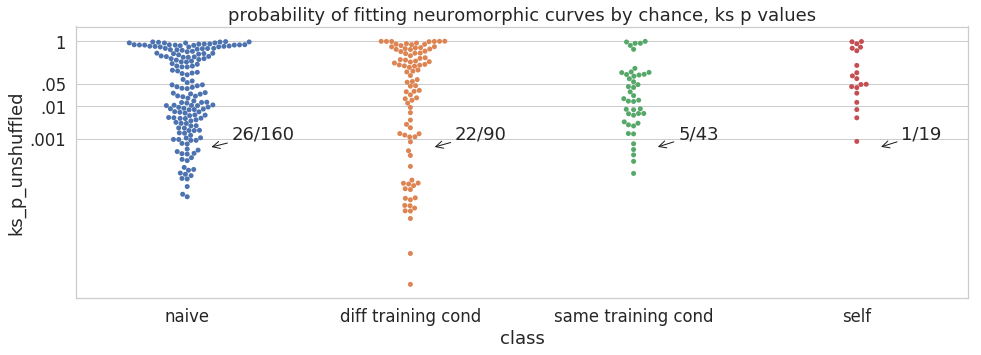

In [188]:
#2048 - ks
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
f = plt.figure(figsize=(16,5))
ax = f.gca()
ax.set_yscale('log')
plt.yticks([1, .05, .01, .001], ['1', '.05', '.01', '.001'])
g = sns.swarmplot(data=all_ks_df, x='class', order=class_order, y='ks_p_unshuffled', size=5, ax=ax)

for i, cls in enumerate(class_order):
    if sig_df.loc[cls, 'ks***'] > 0:
        label = '%d/%d' % (sig_df.loc[cls, 'ks***'], sig_df.loc[cls, 'count'])
        plt.annotate(label, xy=(0.1 + i, floor_val * 1.1), arrowprops=dict(arrowstyle='->', color='k'), xytext=(0.2 + i, floor_val * 2.0));
ax.set_title('probability of fitting neuromorphic curves by chance, ks p values');

In [162]:
def pairwise_sig(all_ks_df, on='p'):
    gb = all_ks_df.groupby('class')
    for cls1, cls2 in itertools.combinations(gb.groups.keys(), 2):
        d, p = sp.stats.mstats.ks_twosamp(gb.get_group(cls1)[on].values, gb.get_group(cls2)[on].values)
        print cls1, cls2, p
print 'p'
pairwise_sig(all_ks_df)
print 'ks_p_unshuffled'
pairwise_sig(all_ks_df, on='ks_p_unshuffled')

p
self naive 0.9655147927236106
self same training cond 0.6331411053863522
self diff training cond 0.48297110150123534
naive same training cond 0.4016895904157547
naive diff training cond 0.13258473360118317
same training cond diff training cond 0.028258060481736916
ks_p_unshuffled
self naive 0.13360858395237826
self same training cond 0.1385846105450036
self diff training cond 0.17754111802903497
naive same training cond 0.04411706146940932
naive diff training cond 0.06562641194897237
same training cond diff training cond 0.006454384992677306


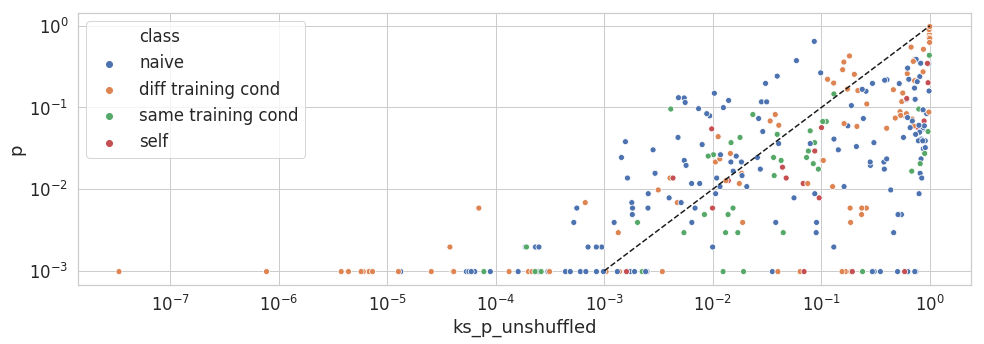

In [159]:
f = plt.figure(figsize=(16,5))
ax = f.gca()
ax.set_yscale('log')
ax.set_xscale('log')
sns.scatterplot(x='ks_p_unshuffled', y='p', hue='class', hue_order=class_order, data=all_ks_df, ax=ax)
unit_line = [1e-3, 1]
plt.plot(unit_line, unit_line, 'k--')

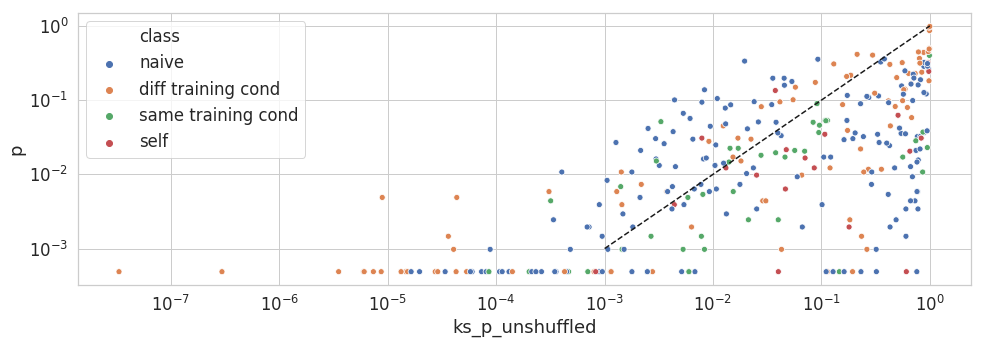

In [189]:
f = plt.figure(figsize=(16,5))
ax = f.gca()
ax.set_yscale('log')
ax.set_xscale('log')
sns.scatterplot(x='ks_p_unshuffled', y='p', hue='class', hue_order=class_order, data=all_ks_df, ax=ax)
unit_line = [1e-3, 1]
plt.plot(unit_line, unit_line, 'k--')

In [145]:
gb = all_ks_df.groupby('class')

In [148]:
gb.get_group('self')

,subj,ks_p_shuffled,ks_stat_unshuffled,ks_p_unshuffled,p,neuro_subj,block_path,class,*,**,***,count,ks*,ks**,ks***
0,B1082,0.351129,0.365585,0.013893,0.012695,B1082,/mnt/cube/mthielk/analysis/B1082/kwik/Pen01_Lf...,self,True,False,False,1,True,False,False
8,B1082,0.407369,0.379654,0.009934,0.005859,B1082,/mnt/cube/mthielk/analysis/B1082/kwik/Pen02_Lf...,self,True,True,False,1,True,True,False
16,B1082,0.440910,0.268051,0.100363,0.056641,B1082,/mnt/cube/mthielk/analysis/B1082/kwik/Pen02_Lf...,self,False,False,False,1,False,False,False
24,B1082,0.548092,0.308678,0.047423,0.013672,B1082,/mnt/cube/mthielk/analysis/B1082/kwik/Pen02_Lf...,self,True,False,False,1,True,False,False
32,B1082,0.581590,0.270912,0.095531,0.007812,B1082,/mnt/cube/mthielk/analysis/B1082/kwik/Pen02_Lf...,self,True,True,False,1,False,False,False
40,B1082,0.523856,0.289848,0.068013,0.011719,B1082,/mnt/cube/mthielk/analysis/B1082/kwik/Pen02_Lf...,self,True,False,False,1,False,False,False
48,B1082,0.413376,0.312599,0.043867,0.018555,B1082,/mnt/cube/mthielk/analysis/B1082/kwik/Pen03_Lf...,self,True,False,False,1,True,False,False
56,B1082,0.497100,0.276253,0.087004,0.029297,B1082,/mnt/cube/mthielk/analysis/B1082/kwik/Pen03_Lf...,self,True,False,False,1,False,False,False
138,B1101,0.971648,0.034164,0.963343,0.201172,B1101,/mnt/cube/mthielk/analysis/B1101/kwik/Pen01_Lf...,self,False,False,False,1,False,False,False
146,B1101,0.970879,0.061714,0.885271,0.068359,B1101,/mnt/cube/mthielk/analysis/B1101/kwik/Pen01_Lf...,self,False,False,False,1,False,False,False


In [151]:
list(itertools.combinations(gb.groups.keys(), 2))

[('self', 'naive'),
 ('self', 'same training cond'),
 ('self', 'diff training cond'),
 ('naive', 'same training cond'),
 ('naive', 'diff training cond'),
 ('same training cond', 'diff training cond')]

In [149]:
import itertools